# Course project: Real Estate Price Prediction

Ваша задача этом соревновании - предсказать цены на квартиры в датасете test.csv. Вам будут даны два датасета: train.csv (содержит признаки и цены на квартиры) и test.csv (только признаки).

#### Структура курсового проекта:
    1. EDA
    2. Обработа исходных признаков
    3. Генерация новых признаков
    4. Обучение модели
    5. Предсказание на тестовых данных

#### Библиотеки:

In [1]:
import numpy as np
import pandas as pd
import random
from scipy.stats import mode
import matplotlib
from matplotlib import pyplot as plt
#import matplotlib.image as img
#import matplotlib.ticker as ticker
import seaborn as sns
from scipy import stats
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [2]:
# # 2. Разделение датасета
# from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# # 3. Модели
# from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor, plot_tree
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
# from sklearn.preprocessing import StandardScaler

# # 4. Метрики качества
# from sklearn.metrics import mean_squared_error as mse, r2_score as r2

#### Путь к данным:

In [66]:
TRAIN_DATASET_PATH = './Desktop/alistale/GB/kaggle/train.csv'
TEST_DATASET_PATH = './Desktop/alistale/GB/kaggle/test.csv'

## EDA

In [67]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')

In [68]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

#### Описание датасета:

    Id - идентификационный номер квартиры
    DistrictId - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры


#### Анализ количественных признаков

In [13]:
df_num_features = train_df.select_dtypes(include=['int64', 'float64'])
df_num_features.drop('Id', axis=1, inplace=True)
df_num_features.drop('DistrictId', axis=1, inplace=True)

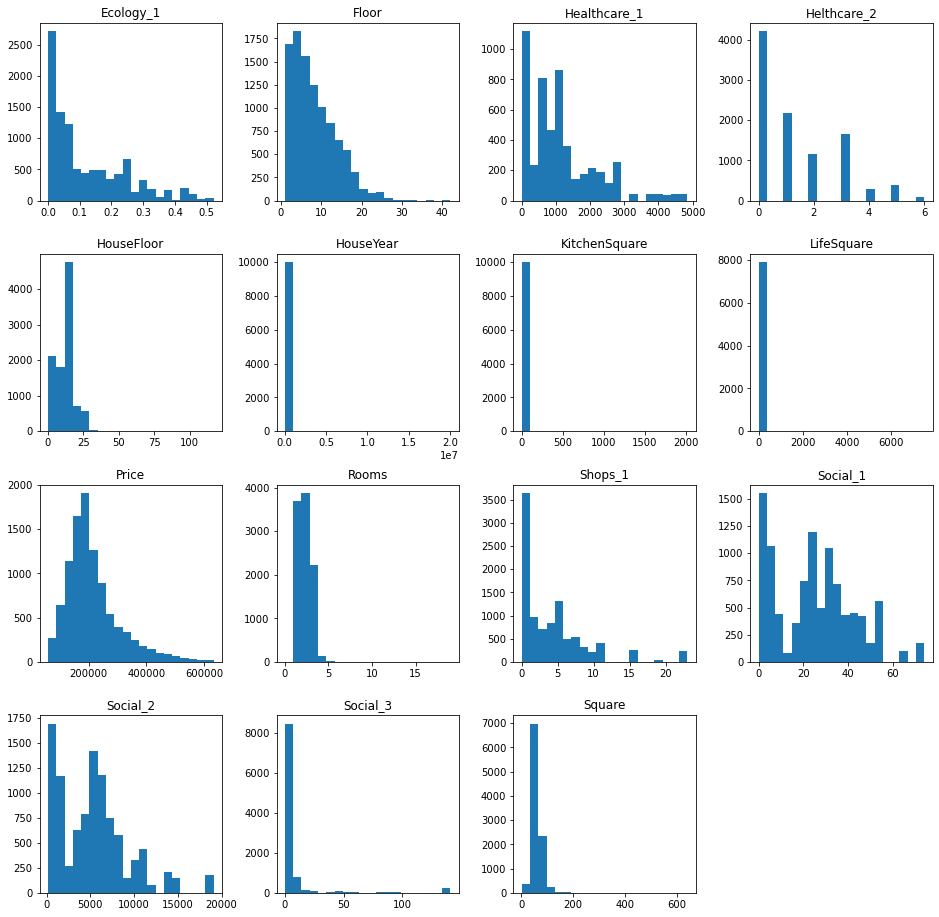

In [14]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

На графиках видны выбросы в признаках LifeSquare, KitchenSquare, Rooms, HouseYear.

#### Анализ категориальных признаков

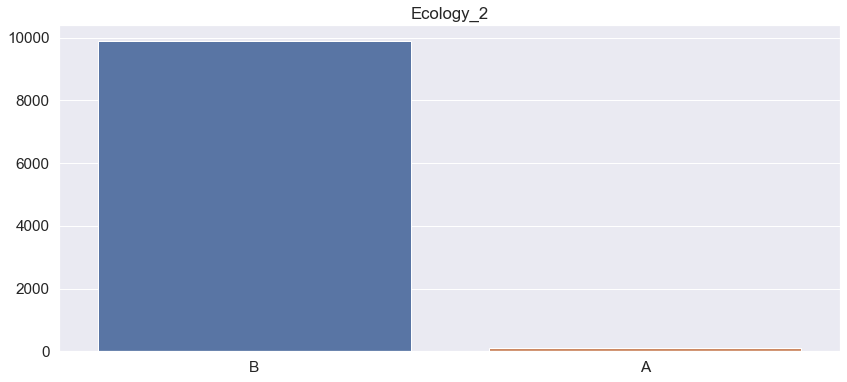

In [21]:
counts = train_df['Ecology_2'].value_counts()
    
plt.figure(figsize=(14,6))    
plt.title('Ecology_2')
sns.barplot(counts.index, counts.values)
    
plt.show()

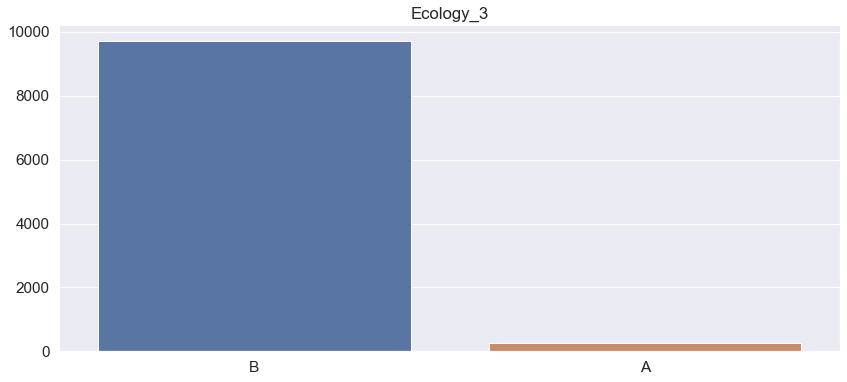

In [31]:
counts = train_df['Ecology_3'].value_counts()
    
plt.figure(figsize=(14,6))    
plt.title('Ecology_3')
sns.barplot(counts.index, counts.values)
    
plt.show()

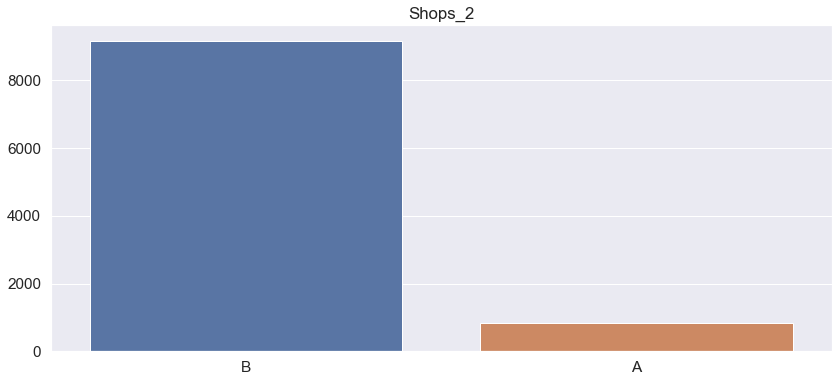

In [32]:
counts = train_df['Shops_2'].value_counts()
    
plt.figure(figsize=(14,6))    
plt.title('Shops_2')
sns.barplot(counts.index, counts.values)
    
plt.show()

Все три категориальных признака имеют ярко выраженный перевес в сторону одной из категорий. Скорее всего, они не сыграют большого значения в процессе обучения модели.

#### Распределение целевой переменной

In [12]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]

print(target_mean, target_median, target_mode)

214138.86 192269.64487934904 59174.77802758122


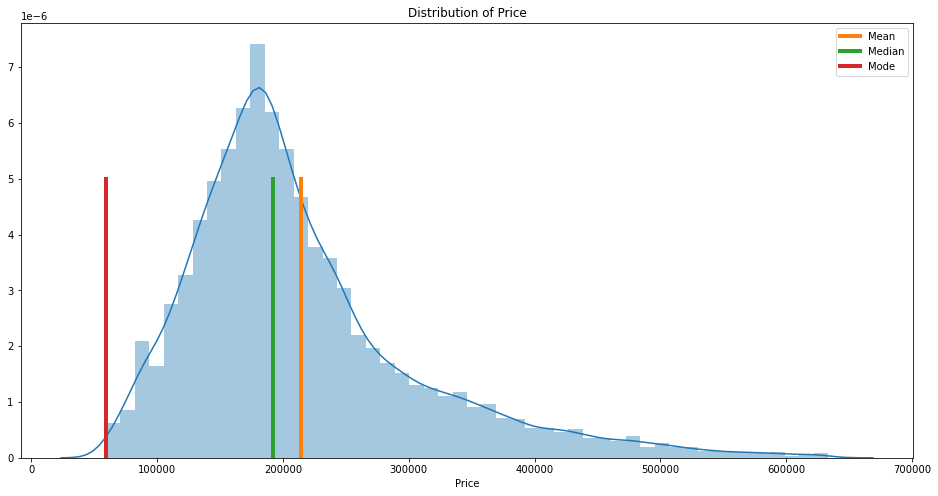

In [10]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='Mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='Median',  linewidth=4)
plt.plot([target_mode] * 10, y, label='Mode', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

В целом, распределение целевой переменной нормальное, но виден некоторый перекос в сторону дешевых квартир. 

#### Матрица корреляции

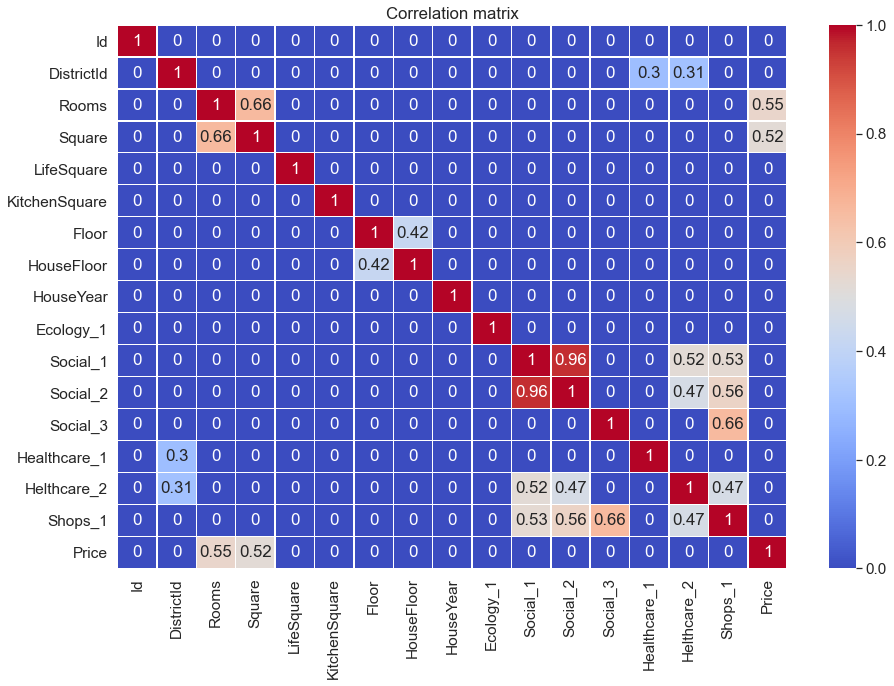

In [15]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

На матрице корреляции видна сильная связь между целевой переменной и признаками Square, Rooms. Признаки Social, Healthcare и Shops также коррелируют между собой, значит в выборке присутствуют "благоприятные" районы.

## Обработа исходных признаков

Обработаем выявленные ранее выбросы и пропуски.

#### Rooms

In [34]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [35]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [36]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

#### KitchenSquare

In [37]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [38]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [39]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

#### HouseFloor, Floor

In [40]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [42]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [43]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [44]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [45]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [46]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [47]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [48]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

#### HouseYear

In [49]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7246        2020
2350        2020
8296        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [50]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

#### LifeSquare

In [51]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

#### Healthcare_1

In [52]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

### Итоговая функция предобработки данных

In [53]:
class DataPreprocessing:

    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
        
    def fit(self, X):
        """Сохранение статистик"""       
        # medians
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)       
        
        
    
    def transform(self, X):
        """Трансформация данных"""

       
        # LifeSquare Outlier
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)        
        
        
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3       
        
        
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = 2020
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year        
        
    
        # Healthcare_1
        X.drop('Healthcare_1', axis=1, inplace=True)
            
        # intToStr
    
        X['Id'] = X['Id'].astype(str)
        X['DistrictId'] = X['DistrictId'].astype(str)     
        
        X.fillna(self.medians, inplace=True)
        
        return X    

## Генерация новых признаков

Создадим новые признаки для датасета:
    1. Переведем категориальные признаки в бинарные
    2. Создадим признак размера района
    3. Создадим признак "большого" района
    4. Создадим признак многокомнатной квартиры
    5. Создадим признак квартиры большой площади
    
    + для каждого нового признака посчитаем среднюю стоимость квартир

Создадим новый признак isManyRooms

In [54]:
train_df['isManyRooms'] = 0
train_df.loc[train_df['Rooms'] > 2, 'isManyRooms'] = 1

Посчитаем среднюю стоимость квартиры на каждую из категорий

In [55]:
manyRooms_medPrice = train_df.groupby(['isManyRooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'manyRooms_medPrice'})
manyRooms_medPrice.head()

,isManyRooms,manyRooms_medPrice
0,0,178860.591507
1,1,276242.223213


In [56]:
train_df = train_df.merge(manyRooms_medPrice, on=['isManyRooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,isManyRooms,manyRooms_medPrice
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,0,0,B,305018.871089,0,0,1,1,276242.223213
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,1,0,B,177734.553407,0,0,0,0,178860.591507
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,3,1,B,282078.720850,0,0,0,1,276242.223213
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,0,0,1,B,168106.007630,0,0,1,0,178860.591507
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,2,0,6,B,343995.102962,0,0,0,0,178860.591507


Создадим новый признак: большая по площади квартира (isLargeSquare)


In [57]:
train_df['isLargeSquare'] = 0
train_df.loc[train_df['Square'] > 90.0, 'isLargeSquare'] = 1

Посчитаем среднюю стоимость большой квартиры

In [58]:
largeSquare_medPrice = train_df.groupby(['isLargeSquare'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'largeSquare_medPrice'})
largeSquare_medPrice.head()

,isLargeSquare,largeSquare_medPrice
0,0,189473.463854
1,1,356332.296643


In [59]:
train_df = train_df.merge(largeSquare_medPrice, on=['isLargeSquare'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,isManyRooms,manyRooms_medPrice,isLargeSquare,largeSquare_medPrice
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,B,305018.871089,0,0,1,1,276242.223213,1,356332.296643
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,B,177734.553407,0,0,0,0,178860.591507,0,189473.463854
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,B,282078.720850,0,0,0,1,276242.223213,0,189473.463854
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,1,B,168106.007630,0,0,1,0,178860.591507,0,189473.463854
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,6,B,343995.102962,0,0,0,0,178860.591507,0,189473.463854


Создание дополнительного признака: размер района

In [60]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [61]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,isManyRooms,manyRooms_medPrice,isLargeSquare,largeSquare_medPrice,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,B,305018.871089,0,0,1,1,276242.223213,1,356332.296643,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,177734.553407,0,0,0,0,178860.591507,0,189473.463854,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,282078.720850,0,0,0,1,276242.223213,0,189473.463854,652
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,B,168106.007630,0,0,1,0,178860.591507,0,189473.463854,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,343995.102962,0,0,0,0,178860.591507,0,189473.463854,89


Дополнительный признак большого района

In [62]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

Создание признака средней цены по размеру района

In [63]:
med_price_by_districtsize = train_df.groupby(['DistrictSize', 'DistrictId'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_districtsize.head()

,DistrictSize,DistrictId,MedPriceByDistrict
0,1,117,386569.255841
1,1,174,421851.953639
2,1,196,336584.118092
3,1,199,432546.129741
4,1,205,220501.566180


In [64]:
train_df = train_df.merge(med_price_by_districtsize, on=['DistrictSize', 'DistrictId'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,isManyRooms,manyRooms_medPrice,isLargeSquare,largeSquare_medPrice,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,0,1,1,276242.223213,1,356332.296643,851,1,146171.433190
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,0,178860.591507,0,189473.463854,78,0,183678.134031
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,1,276242.223213,0,189473.463854,652,1,183663.443595
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,0,0,1,0,178860.591507,0,189473.463854,652,1,183663.443595
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,0,0,178860.591507,0,189473.463854,89,0,181706.718894


Приведем признак DistrictId и Id к строковому формату

In [69]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

 ### Итоговая функция генерации новых фичей

In [70]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        
        self.med_price_by_districtsize = None
        self.manyRooms_medPrice = None        
        self.largeSquare_medPrice = None     
        
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        X['isManyRooms'] = 0
        X.loc[X['Rooms'] > 2, 'isManyRooms'] = 1      
        
        X['isLargeSquare'] = 0
        X.loc[X['Square'] > 90.0, 'isLargeSquare'] = 1
        
        
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        
        ## DistrictSize, DistrictId    
        if y is not None:
            df['Price'] = y.values
            self.med_price_by_districtsize = df.groupby(['DistrictSize', 'DistrictId'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrictSize'})
            
            self.med_price_by_districtsize_median = self.med_price_by_districtsize['MedPriceByDistrictSize'].median()
            
        
        ## isManyRooms          
        if y is not None:
            df['Price'] = y.values
            self.manyRooms_medPrice = df.groupby(['isManyRooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'manyRooms_medPrice'})
      
            self.manyRooms_medPrice_median = self.manyRooms_medPrice['manyRooms_medPrice'].median()
    
    
        ## isLargeSquare        
        if y is not None:
            df['Price'] = y.values
            self.largeSquare_medPrice = df.groupby(['isLargeSquare'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'largeSquare_medPrice'})
            
            self.largeSquare_medPrice_median = self.largeSquare_medPrice['largeSquare_medPrice'].median()
            
   
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        X['isManyRooms'] = 0
        X.loc[X['Rooms'] > 2, 'isManyRooms'] = 1      
        
        X['isLargeSquare'] = 0
        X.loc[X['Square'] > 90.0, 'isLargeSquare'] = 1
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
            
        if self.med_price_by_districtsize is not None:
            X = X.merge(self.med_price_by_districtsize, on=['DistrictId', 'DistrictSize'], how='left')
            X.fillna(self.med_price_by_districtsize_median, inplace=True)
            
        if self.manyRooms_medPrice is not None:
            X = X.merge(self.manyRooms_medPrice, on=['isManyRooms'], how='left')
            X.fillna(self.manyRooms_medPrice_median, inplace=True)
            
        if self.largeSquare_medPrice is not None:
            X = X.merge(self.largeSquare_medPrice, on=['isLargeSquare'], how='left')
            X.fillna(self.largeSquare_medPrice_median, inplace=True)
            
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
        

## Обучение модели

In [71]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

preprocessor = DataPreprocessing()
preprocessor.fit(train_df)

train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)
train_df.shape, test_df.shape

((10000, 23), (5000, 22))

In [72]:
features_gen = FeatureGenetator()
features_gen.fit(train_df.drop(columns='Price'), train_df['Price'])

train_df = features_gen.transform(train_df)
test_df = features_gen.transform(test_df)
train_df.shape, test_df.shape

((10000, 35), (5000, 34))

In [73]:
train_df.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0)

In [74]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [75]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'LifeSquare_nan',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'HouseYear_outlier',
 'DistrictSize',
 'new_district',
 'IsDistrictLarge',
 'isManyRooms',
 'isLargeSquare',
 'floor_cat',
 'year_cat',
 'MedPriceByDistrict',
 'MedPriceByFloorYear',
 'MedPriceByDistrictSize',
 'manyRooms_medPrice',
 'largeSquare_medPrice']

In [76]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 
                 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names =  ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'DistrictSize', 'new_district',
                      'IsDistrictLarge', 'isManyRooms', 'isLargeSquare', 'floor_cat', 'year_cat', 'MedPriceByDistrict',
                      'MedPriceByFloorYear', 'MedPriceByDistrictSize', 'manyRooms_medPrice', 'largeSquare_medPrice']
target_name = 'Price'

In [77]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

test_df = test_df[feature_names + new_feature_names]

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

В качестве финальной модели используем VotingRegressor.

In [79]:
model1 = GradientBoostingRegressor(n_estimators=442, max_depth=5, min_samples_split=2,
                                           learning_rate=0.1, loss='ls', random_state=42)

model2 = RandomForestRegressor(n_estimators=1442, max_depth=18, random_state=42, max_features=7)

model = VotingRegressor([('model1', model1), ('model2', model2)])

model.fit(X_train, y_train)

VotingRegressor(estimators=[('model1',
                             GradientBoostingRegressor(max_depth=5,
                                                       n_estimators=442,
                                                       random_state=42)),
                            ('model2',
                             RandomForestRegressor(max_depth=18, max_features=7,
                                                   n_estimators=1442,
                                                   random_state=42))])

Train R2:	0.965
Test R2:	0.771


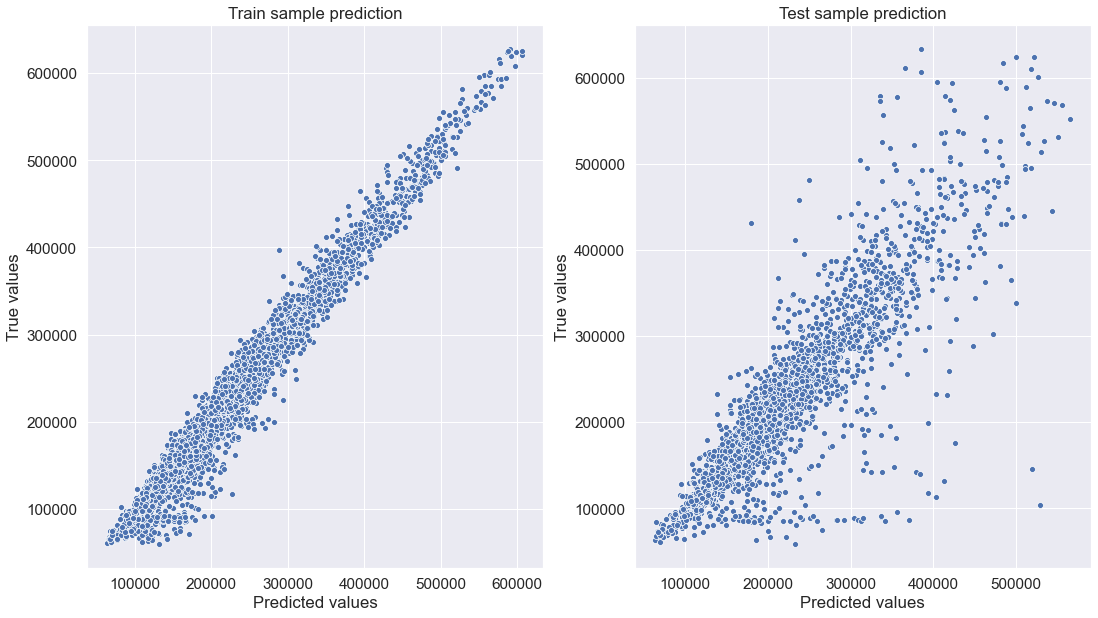

In [80]:
y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [81]:
model1.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=442, random_state=42)

In [82]:
model2.fit(X_train, y_train)

RandomForestRegressor(max_depth=18, max_features=7, n_estimators=1442,
                      random_state=42)

In [83]:
model1.feature_importances_

array([2.56541648e-03, 1.21424093e-01, 3.14655283e-02, 1.26893549e-02,
       1.06196050e-02, 1.91386016e-02, 1.84481560e-02, 1.19865824e-02,
       3.16095254e-04, 1.40679784e-03, 1.00867483e-02, 1.49461080e-02,
       1.66804678e-02, 3.79593758e-03, 4.73827845e-03, 9.22984905e-04,
       6.80197627e-05, 1.38927023e-03, 1.38374296e-05, 1.92089612e-02,
       0.00000000e+00, 1.55793741e-04, 1.01258780e-03, 8.09083826e-05,
       1.39842767e-03, 9.71365337e-04, 6.38412686e-01, 2.20690892e-02,
       3.25120349e-02, 5.87100836e-04, 8.89161337e-04])

In [84]:
model2.feature_importances_

array([5.87884410e-02, 1.56990568e-01, 5.19056991e-02, 2.08170620e-02,
       1.56991178e-02, 2.05058461e-02, 2.52375289e-02, 1.59430746e-02,
       1.64553223e-04, 1.09052848e-03, 2.90457093e-02, 3.25347053e-02,
       2.27696167e-02, 9.66781592e-03, 1.30322724e-02, 1.16548048e-03,
       1.29733858e-04, 2.58260205e-03, 3.07287848e-06, 4.85357298e-02,
       0.00000000e+00, 1.01347871e-02, 3.23912833e-02, 9.15166706e-03,
       7.27011455e-03, 8.06064863e-03, 2.51818605e-01, 2.34713551e-02,
       8.45269475e-02, 3.61588985e-02, 1.04065343e-02])

In [85]:
feature_importances1 = pd.DataFrame(zip(X_train.columns, 
                                       model1.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances1.sort_values(by='importance', ascending=False, inplace=True)

In [86]:
feature_importances2 = pd.DataFrame(zip(X_train.columns, 
                                       model2.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances2.sort_values(by='importance', ascending=False, inplace=True)

In [87]:
feature_importances1.head(3)

,feature_name,importance
26,MedPriceByDistrict,0.638413
1,Square,0.121424
28,MedPriceByDistrictSize,0.032512


In [88]:
feature_importances2.head(3)

,feature_name,importance
26,MedPriceByDistrict,0.251819
1,Square,0.156991
28,MedPriceByDistrictSize,0.084527


In [89]:
feature_importances1.tail(3)

,feature_name,importance
16,Rooms_outlier,0.000068
18,HouseYear_outlier,0.000014
20,new_district,0.000000


In [90]:
feature_importances2.tail(3)

,feature_name,importance
16,Rooms_outlier,0.000130
18,HouseYear_outlier,0.000003
20,new_district,0.000000


### Кросс валидация

In [91]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, GridSearchCV

In [92]:
cv_score = cross_val_score(model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.76827878, 0.76581177, 0.78984965])

In [93]:
cv_score.mean()

0.7746467341315509

## Предсказание на тестовых данных

In [94]:
submit = pd.read_csv('./Desktop/alistale/GB/kaggle/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [95]:
predictions = model.predict(test_df)
predictions

array([166141.03811882, 125298.10920423, 135280.11691347, ...,
       149993.53084201, 181812.48655923, 269687.45959698])

In [96]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,166141.038119
1,5925,125298.109204
2,960,135280.116913
3,3848,126627.472257
4,746,181280.856486


In [97]:
submit.to_csv('./Desktop/alistale/GB/kaggle/tsygantsova_submission.csv', index=False)